# Dataset Visualization Preview
This dataset contains the information regarding county subdivisions across the United States. The data includes subdivision names, state names, and the area measurements of the counties. 

## Visualization of the United States Map with Geopandas

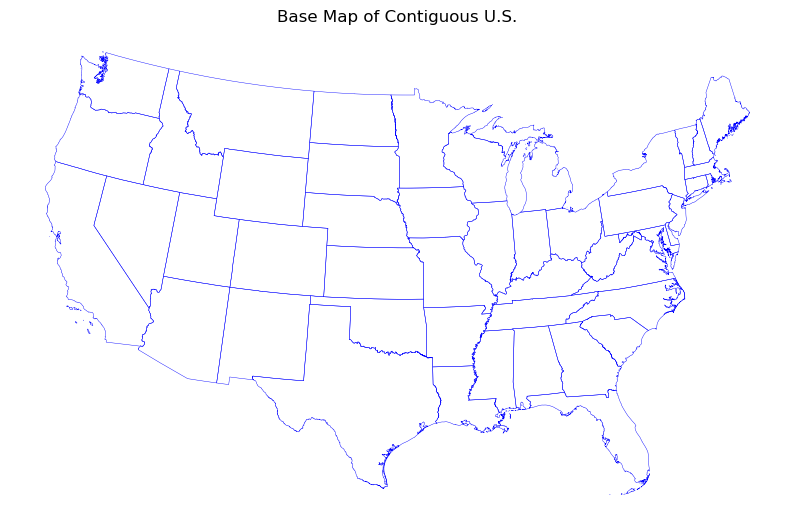

In [150]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Read the file
data = geopandas.read_file('data/cb_2020_us_cousub_500k.shp')

# Filter out territories, Alaska, and Hawaii
contiguous = data[~data['STUSPS'].isin(['AK', 'HI', 'PR', 'VI', 'GU', 'MP', 'AS'])] 

# Disolve to state level over county area
states = contiguous.dissolve(by='STUSPS', as_index=False)
states = states.to_crs(epsg=5070)

# Plot base map
fig, ax = plt.subplots(figsize=(10, 8))
states.boundary.plot(ax=ax, linewidth=0.3, color='blue')
ax.set_title("Base Map of Contiguous U.S.")
plt.savefig('Jamie_USBaseMap.png')
ax.set_axis_off()
plt.show()

## Purpose and Insight
This visualization shows the spatial density of tornados across the US. From this map we can see which states and regions in those states that have the most common tornado occurance and severity. Using this map we can identify which places/states are safest in the case of an evacuation or for future constructuon reference.

## Visualization #1: Number of County Divisions per State

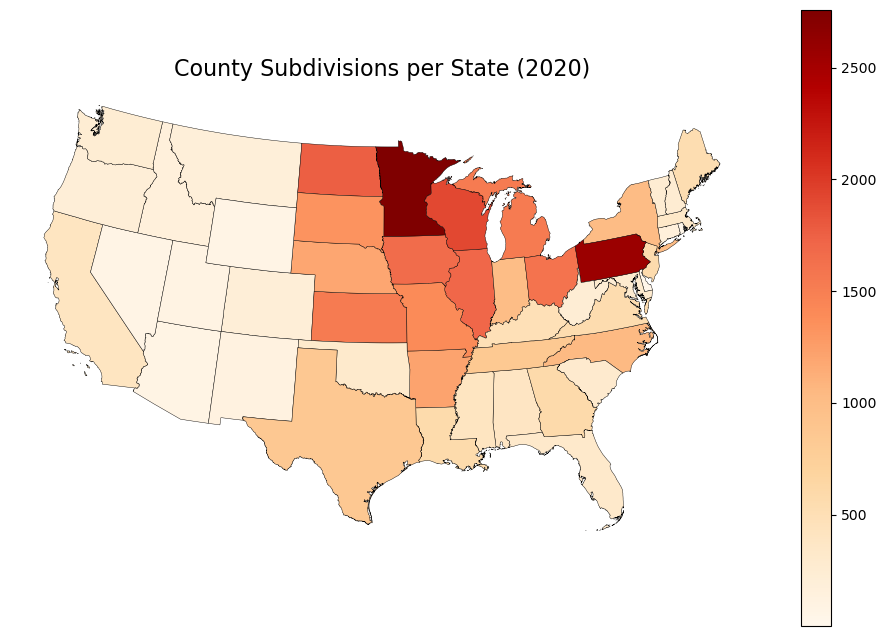

In [116]:
# Count subdivisions per state and merge with states geometry
counts = contiguous.groupby('STUSPS').size().reset_index(name='count')
states = states.merge(counts, on='STUSPS')

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
states.plot(column='count', cmap='OrRd', legend=True, 
           edgecolor='black', linewidth=0.3, ax=ax)
ax.set_title("County Subdivisions per State (2020)", fontsize=16)
ax.set_axis_off()
plt.savefig('Jamie_SubdivisionsChoropleth.png', bbox_inches='tight')
plt.show()

## Purpose and Insight
This map colors the states based on the number of subdivisions present in that state. From the visualizations we can see that Pennsylvania and Minnesota have the highest recorded subdivisions, over 2500 while states like Nevada and Wyoming have the lowest recorded subdivision, under 500. We would expect to see larger states like Texas and California to be the states with the most subdivisions but that is not true according to the data. 

## Visualization #2: Top 10 States by Subdivision

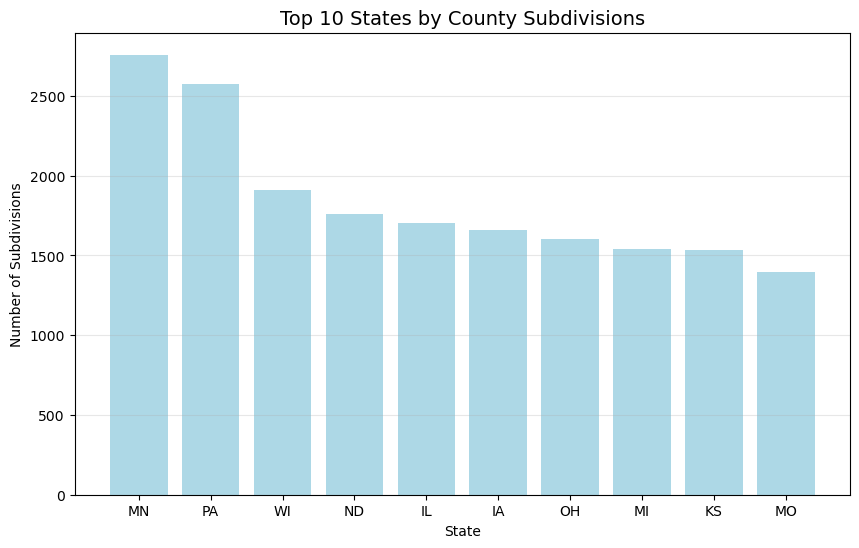

In [158]:
# Sort and plot top 10 states
top10 = counts.sort_values('count', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.bar(top10['STUSPS'], top10['count'], color='lightblue')
plt.title('Top 10 States by County Subdivisions', fontsize=14)
plt.xlabel('State')
plt.ylabel('Number of Subdivisions')
plt.grid(axis='y', alpha=0.3)
plt.savefig('Jamie_Top10Subdivisions.png', bbox_inches='tight')
plt.show()

## Purpose and Insight
This bar chart displays the top 10 states with the largest subdivisions. This visualization is a continuation of the choropleth map as it breaks down the data into a more digestable form. From the visualization we can see that Minnesota is the state with the largest subdivisions, followed by Pennsylvania, and Wisconsin. From the visualization we can see that North Dakota ranked fourth which is odd as the state has a below average population compared to medium sized state. 

## Visualization #3: Distribution of Subdivision Areas

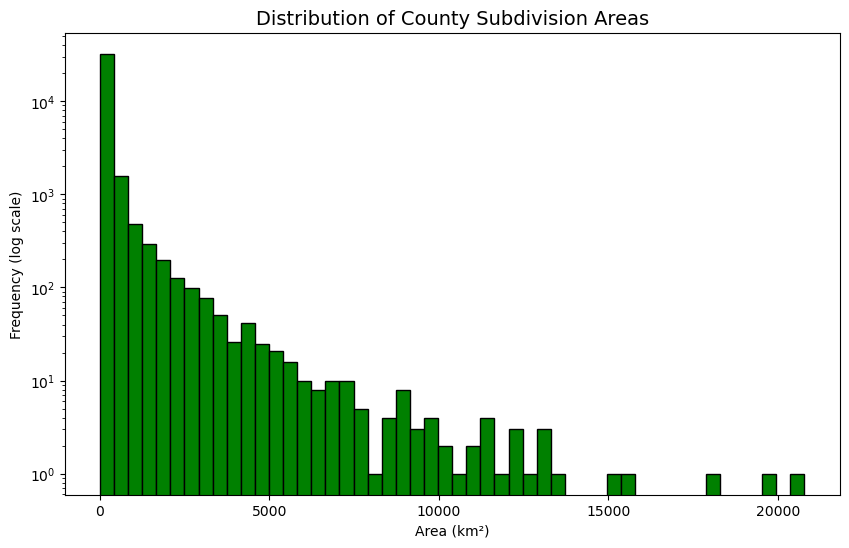

In [137]:
# Calculate area in km²
contiguous = contiguous.to_crs(epsg=5070)  # Ensure projected CRS
contiguous['area_km2'] = contiguous.geometry.area / 1e6

# Plot
plt.figure(figsize=(10, 6))
plt.hist(contiguous['area_km2'], bins=50, color='green', 
        edgecolor='black', log=True)
plt.title('Distribution of County Subdivision Areas', fontsize=14)
plt.xlabel('Area (km²)')
plt.ylabel('Frequency (log scale)')
plt.savefig('Jamie_SubDivisionSize.png', bbox_inches='tight')
plt.show()

## Purpose and Insight
This histogram shows the average size of subdivisions in a state. From the visualization we can see that the vast majority of subdivisions are under 1,000km2. This would explain why states like Minnesota and Pennsylvania are so densely populated with subdivisions despite not being the largest states. From the visualization we can also see that there is a sparce number of subdivisions that are over or around 20,000km2, we can assume these subdivisions are from states that are not as populated, such as Montana or Wyoming. 

## Visualization #4: State Area vs. Tornado Count

<Figure size 1200x600 with 0 Axes>

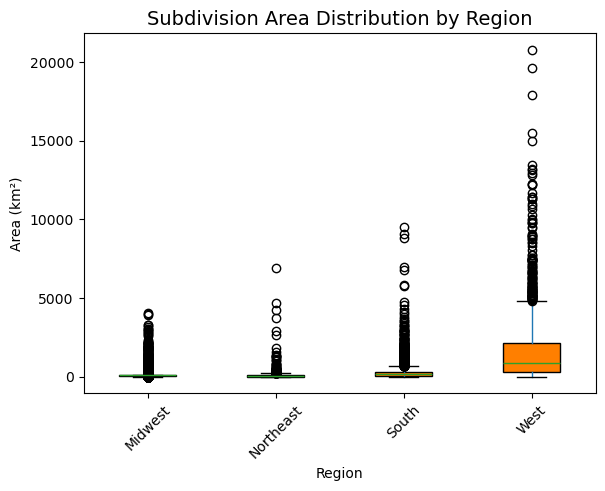

In [142]:
# Assign regions (Northeast, Midwest, South, West)
region_mapping = {
    'Northeast': ['CT','ME','MA','NH','RI','VT','NJ','NY','PA'],
    'Midwest': ['IL','IN','IA','KS','MI','MN','MO','NE','ND','OH','SD','WI'],
    'South': ['AL','AR','DE','FL','GA','KY','LA','MD','MS','NC','OK','SC','TN','TX','VA','WV'],
    'West': ['AZ','CA','CO','ID','MT','NV','NM','OR','UT','WA','WY']
}
contiguous['region'] = contiguous['STUSPS'].map(
    {st: reg for reg, states in region_mapping.items() for st in states}
)

# Plot
plt.figure(figsize=(12, 6))
contiguous.dropna().boxplot(column='area_km2', by='region', grid=False, 
                           patch_artist=True, 
                           boxprops=dict(facecolor='#ff7f00'))
plt.title('Subdivision Area Distribution by Region', fontsize=14)
plt.suptitle('')
plt.xlabel('Region')
plt.ylabel('Area (km²)')
plt.xticks(rotation=45)
plt.savefig('Jamie_RegionBoxplot.png', bbox_inches='tight')
plt.show()

## Purpose and Insight
This box plot shows the regional differences in statae subdivision sizes. The states are separated into their regions, Midwest, Northeast, South, and West. From the visualization we can see that regional subdivisions are a reflection of historical settlements and land distribution. This can be seen heavily in the Norteast region as that area valued local governance while the West region was impacted by lim

## Visualization #5: 

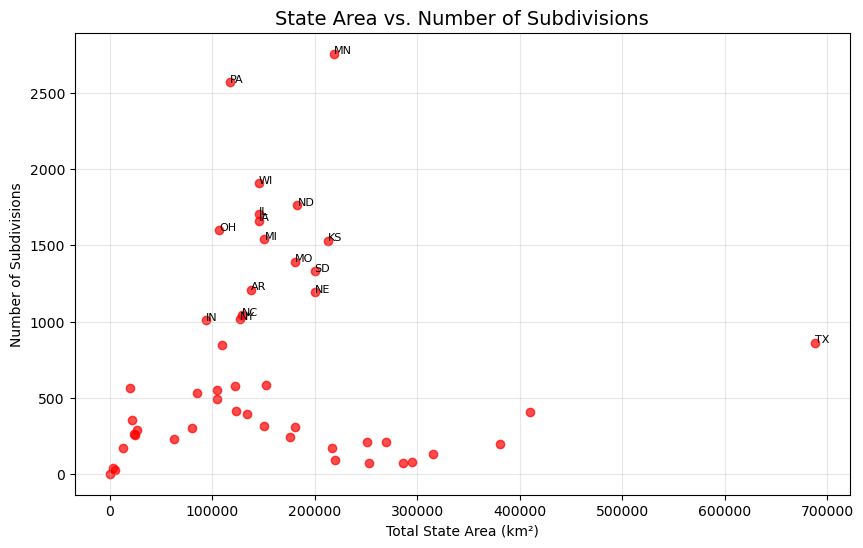

In [148]:
# Calculate total area per state
state_area = contiguous.groupby('STUSPS')['area_km2'].sum().reset_index(name='state_area')
merged = counts.merge(state_area, on='STUSPS')

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(merged['state_area'], merged['count'], alpha=0.7, color='red')
plt.title('State Area vs. Number of Subdivisions', fontsize=14)
plt.xlabel('Total State Area (km²)')
plt.ylabel('Number of Subdivisions')
plt.grid(alpha=0.3)

# Label outliers
for _, row in merged.iterrows():
    if row['count'] > 1000 or row['state_area'] > 5e5:
        plt.text(row['state_area'], row['count'], row['STUSPS'], fontsize=8)

plt.savefig('Jamie_StateArea.png', bbox_inches='tight')
plt.show()

## Purpose and Insight
This scatter plot displays the relationship between the size of a state and the number of subdivisions inside that state. From the visualization we can see that Pennsylvania and Minnesota are considered the largest outliers as they have a large number  of subdivisions compared to their total state area. From the visualization we can also see the great difference between most states and Texas, as the largest state separated from all other states as despite their large total state area, they have a slightly above average number of subdivisions. 